In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.commands import SamplePulse

In [2]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
freq_qubit = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {freq_qubit/ GHz} GHz.")

# scale data
scale_factor = 1e-10

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)

Qubit 0 has an estimated frequency of 4.974292453469106 GHz.


In [3]:
def get_closest_multiple_of_16(num):
    return (int(num) - (int(num)%16))

In [4]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

# Drive pulse samples
freq_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=0.3,
                                 name='freq_sweep_excitation_pulse')

In [5]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[0])

In [6]:
# Calculate amplitude from complex signal
# Takes in complex vector and returns real vector encoding the signal
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)

In [7]:
# apparently np.c_ also does this (column stack)
def reshape_complex_vec(vec):
    '''Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        vec_reshaped (list): vector w/ entries given by (real(vec], imag(vec))
    '''
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [8]:
NUM_SHOTS = 512
# Returns freqs array and assembled freq_qobj
def create_ground_freq_sweep_program(freq_step, freq_span):
    """
    Builds a qobj that does a freq sweep for the 0->1 transition.
    Args:
        num_freq (int): number of frequencies used
        freq_pm (float): plus/minus frequency range
        drive_power (float) : value of drive amplitude
        shots (int): number of shots over which to do the experiment
    Returns:
        freqs, freq_sweep_qobj (list, qobj): frequency list and qobj for freq sweep experiments
    """
    # construct frequency list
    freqs = freq_qubit + np.arange(-freq_span/2, freq_span/2, freq_step)
    
    print(f"The sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
in steps of {freq_step / MHz} MHz.")
    
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    schedule += freq_sweep_drive_pulse(drive_chan)
    schedule += measure << schedule.duration

    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble freq sweep qobj
    freq_sweep_program = assemble(schedule,
                               backend=backend, 
                               meas_level=1,
                               meas_return='avg',
                               shots=NUM_SHOTS,
                               schedule_los=schedule_freqs)
    
    return freqs, freq_sweep_program

In [9]:
# We will sweep 40 MHz around the estimated frequency
freq_span = 40 * MHz
# in steps of 1 MHz.
freq_step = 1 * MHz
sweep_freqs, freq_sweep_program = create_ground_freq_sweep_program(freq_step, freq_span)

The sweep will go from 4.9542924534691055 GHz to 4.993292453469106 GHz in steps of 1.0 MHz.


In [10]:
job = backend.run(freq_sweep_program)

In [11]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [12]:
def get_job_data(job):
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        result = job_results.get_memory(i)#*scale_factor
        result_data.append(result[qubit])
        
    return result_data

In [13]:
sweep_data = get_job_data(job)
print(sweep_data)
#sweep_data = get_amplitude(sweep_data)

[(-67678215602176+172321184677888j), (-58188707659776+183773765304320j), (-68094001152000+148795568422912j), (-53158529204224+189527075323904j), (-70454425419776+165941094645760j), (-72130804842496+164070216957952j), (-62451336871936+162809123962880j), (-64108732874752+178705066360832j), (-76549730598912+169669730238464j), (-73184665665536+172635841363968j), (-41046377496576+213305121570816j), (-74365437739008+168633468715008j), (-57336974540800+185258498588672j), (-56484876517376+179381121056768j), (-59695591063552+191872966328320j), (-56558486552576+195477232418816j), (-61368019451904+177787889516544j), (-20011919867904+152734640635904j), (105312203833344+185826055028736j), (383233892024320+168269403127808j), (513455119400960+177407365480448j), (372227870556160+170643328860160j), (113937831952384+172133531516928j), (-9691555954688+196803236462592j), (-70444333924352+149198422933504j), (-54258942607360+183190220177408j), (-58785980743680+143204812849152j), (-74899934674944+14030478717

In [14]:
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [15]:
fit_params, y_fit = fit_function(sweep_freqs,
                                 sweep_data, 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-2e10, 4.975, 1, 3e10] # initial parameters for curve_fit
                                )

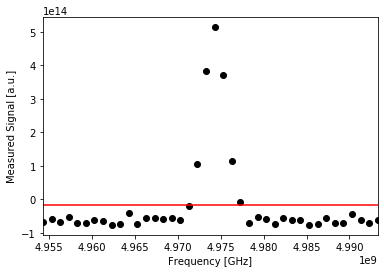

In [16]:
plt.scatter(sweep_freqs, sweep_data, color='black')
plt.plot(sweep_freqs, y_fit, color='red')
plt.xlim([min(sweep_freqs), max(sweep_freqs)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [17]:
### Construct the measurement pulse
# Measurement pulse parameters

meas_samples_us = 3.0
meas_sigma_us = 0.014     # The width of the gaussian part of the rise and fall
meas_risefall_us = 0.1    # and the truncating parameter: how many samples to dedicate to the risefall

meas_samples = get_closest_multiple_of_16(meas_samples_us * 1e-6/dt)
meas_sigma = get_closest_multiple_of_16(meas_sigma_us * 1e-6/dt)         # The width of the gaussian part of the rise and fall
meas_risefall = get_closest_multiple_of_16(meas_risefall_us * 1e-6/dt)     # and the truncating parameter: how many samples to dedicate to the risefall

# meas_samples = 12800
# meas_sigma = 64         # The width of the gaussian part of the rise and fall
# meas_risefall = 400     # and the truncating parameter: how many samples to dedicate to the risefall

meas_amp = 0.25
# Measurement pulse samples
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples,
                                       sigma=meas_sigma,
                                       amp=meas_amp,
                                       risefall=meas_risefall,
                                       name='measurement_pulse')

### Construct the acquire pulse to trigger the acquisition
# Acquire pulse samples
acq_cmd = pulse.Acquire(duration=meas_samples)

In [18]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [19]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [20]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += drive_pulse(drive_chan)

# In a new schedule, which we will use again later, add a measurement stimulus on the
# measure channel pulse to trigger readout
measure_schedule = meas_pulse(meas_chan)
# Trigger data acquisition, and store measured values into respective memory slots
measure_schedule += acq_cmd([pulse.AcquireChannel(i) for i in backend_config.meas_map[meas_map_idx]],
                            [pulse.MemorySlot(i) for i in backend_config.meas_map[meas_map_idx]])
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure_schedule << schedule.duration

# Create the frequency settings for the sweep
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_GHz]

NameError: name 'drive_pulse' is not defined

In [ ]:
schedule.draw(channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [ ]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [ ]:
job = backend.run(frequency_sweep_program)

In [ ]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

In [ ]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds